In [1]:
from typing import Tuple

import torch
import h5py
import librosa
from torch import Tensor


class TwoPortResistorVector(torch.nn.Module):
    def __init__(self, Z: torch.Tensor):
        super(TwoPortResistorVector, self).__init__()
        
        # self.s11 = torch.nn.Parameter(torch.rand(()))
        # self.s12 = torch.nn.Parameter(torch.rand(()))
        # self.s21 = torch.nn.Parameter(torch.rand(()))
        # self.s22 = torch.nn.Parameter(torch.rand(()))

        self.R1 = torch.tensor(23e3)
        self.R2 = torch.tensor(12e3)
        self.R = torch.diag(torch.tensor([self.R1, self.R2]))
        self.Z = Z
        self.Z_inv = torch.inverse(self.Z)
        self.S = torch.inverse(self.R @ self.Z_inv + torch.eye(2)) @ (self.R @ self.Z_inv - torch.eye(2))

    def forward(self, a: torch.Tensor):
        # b1 = x[0, 0] * self.s11 + x[1, 0] * self.s12
        # b2 = x[0, 0] * self.s21 + x[1, 0] * self.s22
        # return torch.stack([b1, b2])

        return self.S @ a


class FuzzStatic(torch.nn.Module):
    def __init__(self, alpha_lin=0.5, alpha_vol=0.5, fs=48e3, s_path="S.hdf5", z_path="Z.hdf5"):
        super(FuzzStatic, self).__init__()
        self.dtype = torch.float64

        # Circuit parameters
        self.C71 = torch.tensor(4.7e-6, dtype=self.dtype)
        self.Rin = torch.tensor(22e3, dtype=self.dtype)
        self.R72 = torch.tensor(50e3, dtype=self.dtype)
        self.C81 = torch.tensor(4.7e-6, dtype=self.dtype)
        self.R81 = torch.tensor(22e3, dtype=self.dtype)
        self.Rout = torch.tensor(100e3, dtype=self.dtype)
        self.C91 = torch.tensor(4.7e-6, dtype=self.dtype)
        self.R_vol = torch.tensor(50e3, dtype=self.dtype)
        self.C94 = torch.tensor(4.7e-6, dtype=self.dtype)

        # Initialize scattering and free-parameter impedance matrices database from HDF5
        self.fs_dict = {
            44.1e3 : 0,
            48e3   : 1,
            88.2e3 : 2,
            96e3   : 3,
            176.4e3: 4,
            192e3  : 5
        }
        with h5py.File(s_path, "r") as file:
            self.S_matlab = torch.as_tensor(file["/S"][:].T).to(dtype=self.dtype)
        with h5py.File(z_path, "r") as file:
            self.Z_matlab = torch.as_tensor(file["/Z"][:].T).to(dtype=self.dtype)

        # Initialize circuit states
        self.set_circuit_states(alpha_lin, alpha_vol, fs)


    def set_circuit_states(self, alpha_lin: float, alpha_vol: float, fs: float):
        self.alpha_lin = alpha_lin
        self.alpha_vol = alpha_vol
        self.fs = fs

        # Initialize scattering matrices
        self.S_S71, self.S_P72 = self.compute_scattering_matrix_port7()
        self.S_P81 = self.compute_scattering_matrix_port8()
        self.S_S91, self.S_P92, self.S_S93, self.S_S94 = self.compute_scattering_matrix_port9()
        self.S, self.S_forward, self.S_backward, self.Z_root = self.compute_scattering_matrix_rtype()

        # Initialize two-port resistor
        # self.two_port_resistor = TwoPortResistorVector(self.Z_t)
        self.R1 = torch.tensor(23e3, dtype=self.dtype)
        self.R2 = torch.tensor(12e3, dtype=self.dtype)
        self.R = torch.diag(torch.tensor([self.R1, self.R2]))
        self.Z_root_inv = torch.inverse(self.Z_root)
        self.Sr = torch.inverse(self.R @ self.Z_root_inv + torch.eye(2)) @ (self.R @ self.Z_root_inv - torch.eye(2))
        # self.Sr = torch.nn.Parameter(torch.zeros((2, 2), dtype=self.dtype), requires_grad=True)

        # Initialize waves
        self.init_waves()


    def compute_scattering_matrix_port7(self):
        Z_R71 = self.Rin
        Z_C71 = 1 / (2 * self.fs * self.C71)
        Z_S71 = torch.stack((
            Z_R71 + Z_C71,
            Z_C71,
            Z_R71
        ))

        Z_R72 = self.R72
        Z_P72 = torch.stack((
            (Z_S71[0] * Z_R72) / (Z_S71[0] + Z_R72),
            Z_R72,
            Z_S71[0]
        ))
        return (
            self.scattering_matrix_series(Z_S71),
            self.scattering_matrix_parallel(Z_P72)
        )


    def compute_scattering_matrix_port8(self):
        Z_R81 = self.R81
        Z_C81 = 1 / (2 * self.fs * self.C81)
        Z_P81 = torch.stack((
            (Z_R81 * Z_C81) / (Z_R81 + Z_C81),
            Z_C81,
            Z_R81
        ))
        return self.scattering_matrix_parallel(Z_P81)


    def compute_scattering_matrix_port9(self):
        Z_R91 = self.Rout
        Z_C91 = 1 / (2 * self.fs * self.C91)
        Z_S91 = torch.stack((
            Z_R91 + Z_C91,
            Z_R91,
            Z_C91
        ))

        R92 = self.alpha_vol * self.R_vol 
        Z_R92 = R92
        Z_P92 = torch.stack((
            (Z_R92 * Z_S91[0]) / (Z_R92 + Z_S91[0]),
            Z_R92,
            Z_S91[0]
        ))        

        R93 = (1 - self.alpha_vol) * self.R_vol
        Z_R93 = R93
        Z_S93 = torch.stack((
            Z_R93 + Z_P92[0],
            Z_R93,
            Z_P92[0]
        ))
        
        Z_C94 = 1 / (2 * self.fs * self.C94)
        Z_S94 = torch.stack((
            Z_C94 + Z_S93[0],
            Z_C94,
            Z_S93[0]
        ))
        
        return (
            self.scattering_matrix_series(Z_S91),
            self.scattering_matrix_parallel(Z_P92),
            self.scattering_matrix_series(Z_S93),
            self.scattering_matrix_series(Z_S94)
        )


    def scattering_matrix_series(self, Z):
        # STEP 0: Formate the free-parameter impedance matrix Z and get the number of ports
        Z = torch.diag(Z)
        num_ports = Z.shape[0]
        
        # STEP 1: Formulate fundamental loop matrix of the series junction
        B = torch.ones(1, num_ports, dtype=self.dtype)
        
        # STEP 2: Calculate the scattering matrix using the general WD junction method
        I = torch.eye(num_ports, dtype=self.dtype)
        S = I - 2 * Z @ B.T @ torch.inverse(B @ Z @ B.T) @ B
        
        # STEP 3: Return the scattering matrix
        return S


    def scattering_matrix_parallel(self, Z):
        # STEP 0: Formate the free-parameter impedance matrix Z and get the number of ports
        Z = torch.diag(Z)
        num_ports = Z.shape[0]
        
        # STEP 1: Formulate fundamental cut-set matrix
        Q = torch.ones(1, num_ports, dtype=self.dtype)
        
        # STEP 2: Calculate the scattering matrix using the general WD junction method
        I = torch.eye(num_ports, dtype=self.dtype)
        Z_inv = torch.inverse(Z)
        S = 2 * Q.T @ torch.inverse(Q @ Z_inv @ Q.T) @ Q @ Z_inv - I
        
        # STEP 3: Return the scattering matrix
        return S


    def compute_scattering_matrix_rtype(self):
        fs_index = self.fs_dict[self.fs]
        alpha_lin_index = round(self.alpha_lin * 100)
        alpha_vol_index = round(self.alpha_vol * 100)

        S = self.S_matlab[fs_index, alpha_lin_index, alpha_vol_index, :, :]
        S_forward = S[0:2, 6:10]
        S_backward = torch.cat((S[6:9, 0:2], S[6:9, 6:10]), dim=1)

        Z = self.Z_matlab[fs_index, alpha_lin_index, alpha_vol_index, :, :]
        Z_root = Z[0:2, 0:2]

        return (
            S,
            S_forward,
            S_backward,
            Z_root
        )


    def init_waves(self):
        # Initial conditions of capacitors computed from DC analysis
        self.a_C71 = torch.tensor(-3.7427606943372482, dtype=self.dtype)
        self.a_C81 = torch.tensor(1.8297941172302856, dtype=self.dtype)
        self.a_C91 = torch.tensor(-4.440665733659135e-12, dtype=self.dtype)
        self.a_C94 = torch.tensor(-5.598253191650242, dtype=self.dtype)
        # self.a_C71 = torch.tensor(0.0, dtype=self.dtype)
        # self.a_C81 = torch.tensor(0.0, dtype=self.dtype)
        # self.a_C91 = torch.tensor(0.0, dtype=self.dtype)
        # self.a_C94 = torch.tensor(0.0, dtype=self.dtype)

        self.b_C71 = torch.tensor(-3.7427606943372482, dtype=self.dtype)
        self.b_C81 = torch.tensor(1.8297941172302856, dtype=self.dtype)
        self.b_C91 = torch.tensor(-4.440665733659135e-12, dtype=self.dtype)
        self.b_C94 = torch.tensor(-5.598253191650242, dtype=self.dtype)

        self.b_S71_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P72_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P81_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S91_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P92_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S93_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S94_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S71_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P81_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S91_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S94_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P72_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P81_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S91_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P92_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S93_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S94_2 = torch.tensor(0.0, dtype=self.dtype)

        self.a0 = torch.tensor(0.0, dtype=self.dtype)
        self.a1 = torch.tensor(0.0, dtype=self.dtype)
        self.a2 = torch.tensor(0.0, dtype=self.dtype)
        self.a3 = torch.tensor(0.0, dtype=self.dtype)
        self.a4 = torch.tensor(0.0, dtype=self.dtype)
        self.a5 = torch.tensor(9.0, dtype=self.dtype)
        self.b0 = torch.tensor(0.0, dtype=self.dtype)
        self.b1 = torch.tensor(0.0, dtype=self.dtype)
        self.b2 = torch.tensor(0.0, dtype=self.dtype)
        self.b3 = torch.tensor(0.0, dtype=self.dtype)
        self.b4 = torch.tensor(0.0, dtype=self.dtype)


    def forward(self, vin):
        vout = torch.zeros_like(vin)

        for i in range(vin.shape[0]):
            # Manage capacitors and inductors' states
            self.b_C71 = self.a_C71
            self.b_C81 = self.a_C81
            self.b_C91 = self.a_C91
            self.b_C94 = self.a_C94

            # Forward scanning
            self.b_S71_0 = self.S_S71[0, 1] * self.b_C71 + self.S_S71[0, 2] * vin[i, 0]
            self.b_P72_0 = self.S_P72[0, 2] * self.b_S71_0
            self.b_P81_0 = self.S_P81[0, 1] * self.b_C81
            self.b_S91_0 = self.S_S91[0, 2] * self.b_C91
            self.b_P92_0 = self.S_P92[0, 2] * self.b_S91_0
            self.b_S93_0 = self.S_S93[0, 2] * self.b_P92_0
            self.b_S94_0 = self.S_S94[0, 1] * self.b_C94 + self.S_S94[0, 2] * self.b_S93_0
            
            self.a2 = self.b_P72_0
            self.a3 = self.b_P81_0
            self.a4 = self.b_S94_0

            # Local scattering
            self.b0 = self.S_forward[0, :] @ torch.stack([self.a2, self.a3, self.a4, self.a5])
            self.b1 = self.S_forward[1, :] @ torch.stack([self.a2, self.a3, self.a4, self.a5])
            self.a0 = self.Sr[0, :] @ torch.stack([self.b0, self.b1])
            self.a1 = self.Sr[1, :] @ torch.stack([self.b0, self.b1])
            self.b2 = self.S_backward[0, :] @ torch.stack([self.a0, self.a1, self.a2, self.a3, self.a4, self.a5])
            self.b3 = self.S_backward[1, :] @ torch.stack([self.a0, self.a1, self.a2, self.a3, self.a4, self.a5])
            self.b4 = self.S_backward[2, :] @ torch.stack([self.a0, self.a1, self.a2, self.a3, self.a4, self.a5])
            
            # Backward scanning
            self.b_P72_2 = self.S_P72[2, 0] * self.b2 + self.S_P72[2, 2] * self.b_S71_0
            self.b_S71_1 = self.S_S71[1, 0] * self.b_P72_2 + self.S_S71[1, 1] * self.b_C71 + self.S_S71[1, 2] * vin[i, 0]
            self.b_P81_1 = self.S_P81[1, 0] * self.b3 + self.S_P81[1, 1] * self.b_C81
            self.b_S94_1 = self.S_S94[1, 0] * self.b4 + self.S_S94[1, 1] * self.b_C94 + self.S_S94[1, 2] * self.b_S93_0
            self.b_S94_2 = self.S_S94[2, 0] * self.b4 + self.S_S94[2, 1] * self.b_C94 + self.S_S94[2, 2] * self.b_S93_0
            self.b_S93_2 = self.S_S93[2, 0] * self.b_S94_2 + self.S_S93[2, 2] * self.b_P92_0
            self.b_P92_2 = self.S_P92[2, 0] * self.b_S93_2 + self.S_P92[2, 2] * self.b_S91_0
            self.b_S91_1 = self.S_S91[1, 0] * self.b_P92_2 + self.S_S91[1, 2] * self.b_C91
            self.b_S91_2 = self.S_S91[2, 0] * self.b_P92_2 + self.S_S91[2, 2] * self.b_C91
            
            self.a_C71 = self.b_S71_1
            self.a_C81 = self.b_P81_1
            self.a_C91 = self.b_S91_2
            self.a_C94 = self.b_S94_1
            
            vout[i, 0] = self.b_S91_1 / 2
        
        return vout


# vin, fs = librosa.load("./matlab/input_fuzz_static.wav", sr=None)
# vin = torch.tensor(vin, dtype=torch.float32).unsqueeze(1)

# model = FuzzStatic()
# model.init_waves()
# v_wdf = model(vin)

In [ ]:
vin, fs = librosa.load("./matlab/input_fuzz_static.wav", sr=None)
vin = torch.tensor(vin, dtype=torch.float32).unsqueeze(1)
v_spice = librosa.load("./matlab/output_fuzz_static.wav", sr=None)[0]
v_spice = torch.tensor(v_spice, dtype=torch.float32).unsqueeze(1)

model = FuzzStatic()
loss_func = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

for epoch in range(200):
    model.init_waves()
    v_wdf = model(vin)
    loss = loss_func(v_wdf, v_spice)
    # loss.backward()
    # optimizer.step()
    # optimizer.zero_grad()
    print(f"Epoch {epoch}: loss = {loss.item()}")

In [ ]:
for epoch in range(200):
    model.init_waves()
    v_wdf = model(vin)
    loss = loss_func(v_wdf, v_spice)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Epoch {epoch}: loss = {loss.item()}")

In [ ]:
model.Sr

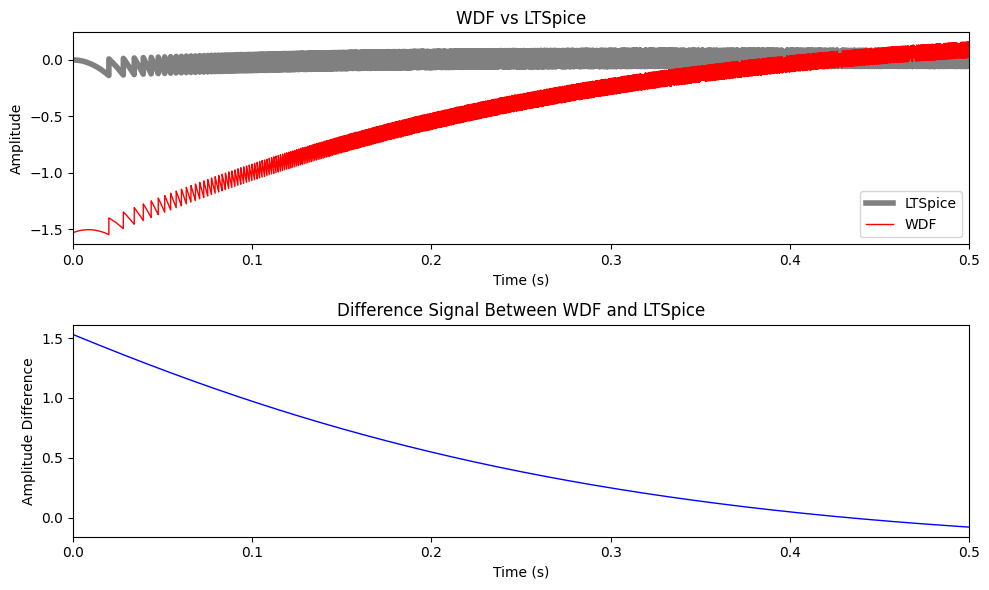

In [2]:
import matplotlib.pyplot as plt
import numpy as np

figsize = (10, 6)
xlim = (0, 0.5)

vin, fs = librosa.load("./matlab/input_fuzz_static.wav", sr=None)
vin = torch.tensor(vin, dtype=torch.float32).unsqueeze(1)
v_spice = librosa.load("./matlab/output_fuzz_static.wav", sr=None)[0]
v_spice = torch.tensor(v_spice, dtype=torch.float32).unsqueeze(1)

model = FuzzStatic()
model.init_waves()
v_wdf = model(vin)

v_wdf_np = v_wdf.detach().numpy().squeeze()
v_spice_np = v_spice.numpy().squeeze()
y_axis = np.linspace(0, v_wdf_np.shape[0] / fs, v_wdf_np.shape[0])

# 创建一个图形和两个子图（ax1 和 ax2）
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

# 在第一个子图上绘制原始信号对比
ax1.plot(y_axis, v_spice_np, color="grey", linewidth=4)
ax1.plot(y_axis, v_wdf_np, color="red", linewidth=1)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.set_title("WDF vs LTSpice")
ax1.legend(["LTSpice", "WDF"])
ax1.set_xlim(xlim)
# ax1.set_xticks(np.arange(0, 5.5, 0.5))

# 计算差值信号
diff_signal = v_spice_np - v_wdf_np

# 在第二个子图上绘制差值信号图
ax2.plot(y_axis, diff_signal, color="blue", linewidth=1)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Amplitude Difference")
ax2.set_title("Difference Signal Between WDF and LTSpice")
ax2.set_xlim(xlim)
# ax2.set_xticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()  # 调整子图的间距
plt.show()